# Emotion Classification with the ISEAR Dataset

Welcome to this Colab notebook, where we explore and implement a machine learning pipeline for **emotion classification** using the **ISEAR Dataset**. This dataset contains textual data describing emotional experiences, labeled with the corresponding emotion.

This notebook demonstrates:
- **Data Preprocessing:** Cleaning and preparing the dataset using NLP techniques such as stopword removal, stemming, and TF-IDF vectorization.
- **Model Training:** Applying various machine learning algorithms, including:
  - Naive Bayes
  - Decision Trees
  - Logistic Regression
  - Random Forest
  - Ensemble Voting Classifier
- **Model Evaluation:** Measuring performance using metrics like accuracy, classification reports, and confusion matrices.

# Step 1: Import necessary libraries

In [1]:
!pip install sentence-transformers

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sentence_transformers import SentenceTransformer

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Step 2: Load and clean the dataset

In [4]:
# Load 'ISEAR_dataset.csv'
df = pd.read_csv('/content/ISEAR_dataset.csv')
# Display first few rows to understand its structure
print(df.head())

  sentiment                                            content Unnamed: 2
0       joy  On days when I feel close to my partner and ot...        NaN
1      fear  Every time I imagine that someone I love or I ...        NaN
2     anger  When I had been obviously unjustly treated and...        NaN
3   sadness  When I think about the short time that we live...        NaN
4   disgust  At a gathering I found myself involuntarily si...        NaN


In [5]:
df.columns = ['EMOTION', 'TEXT', 'Unnamed']
df = df.drop(columns=['Unnamed'])
df.head()

,EMOTION,TEXT
0,joy,On days when I feel close to my partner and ot...
1,fear,Every time I imagine that someone I love or I ...
2,anger,When I had been obviously unjustly treated and...
3,sadness,When I think about the short time that we live...
4,disgust,At a gathering I found myself involuntarily si...


# Step 3: Data exploration

Missing Values:
EMOTION    0
TEXT       0
dtype: int64
EMOTION
joy        1092
sadness    1082
anger      1079
fear       1076
shame      1071
disgust    1066
guilt      1049
guit          1
Name: count, dtype: int64
EMOTION
joy        1092
sadness    1082
anger      1079
fear       1076
shame      1071
disgust    1066
guilt      1050
Name: count, dtype: int64


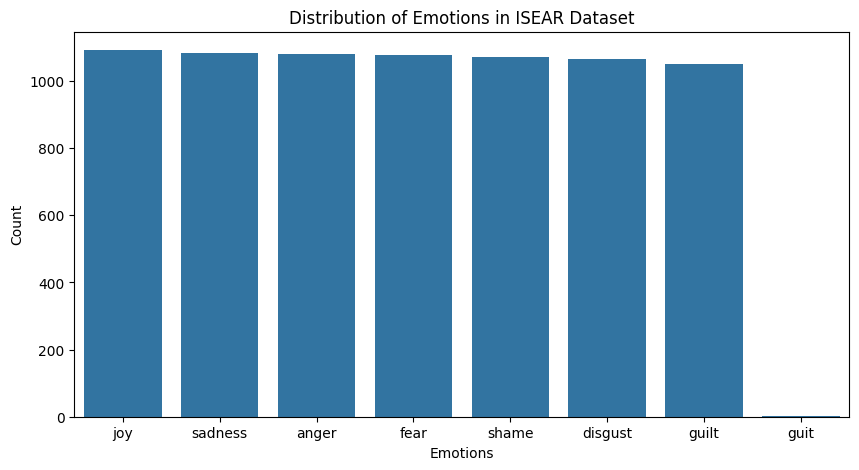

In [6]:
# Check for any missing values
print("Missing Values:")
print(df.isnull().sum())

# Check the distribution of emotions in the dataset
emotion_counts = df['EMOTION'].value_counts()
print(emotion_counts)


# Replace 'guit' with 'guilt' in the EMOTION column
df['EMOTION'] = df['EMOTION'].replace('guit', 'guilt')

# Verify the change by checking the updated counts
print(df['EMOTION'].value_counts())

# Plot emotion distribution
plt.figure(figsize=(10, 5))
sns.barplot(x=emotion_counts.index, y=emotion_counts.values)
plt.title("Distribution of Emotions in ISEAR Dataset")
plt.xlabel("Emotions")
plt.ylabel("Count")
plt.show()

# Step 4: Text Preprocessing

In [7]:
def preprocess_text(data, text_column, new_column='cleaned_text'):
    # Copy original text to a new column if specified
    data[new_column] = data[text_column].copy()

    # Convert uppercase letters to lowercase
    data[new_column] = data[new_column].apply(lambda a: " ".join(a.lower() for a in a.split()))

    # Remove special characters
    data[new_column] = data[new_column].apply(lambda a: " ".join(a.replace('[^\w\s]', '') for a in a.split()))

    # Remove stop words
    stop = set(stopwords.words('english'))
    data[new_column] = data[new_column].apply(lambda a: " ".join(word for word in a.split() if word not in stop))

    # Stemming
    st = PorterStemmer()
    data[new_column] = data[new_column].apply(lambda a: " ".join(st.stem(word) for word in a.split()))

    return data

df = preprocess_text(df,'TEXT')

In [8]:
# Save the processed DataFrame to a new CSV file
df.to_csv('ISEAR_Cleaned.csv', index=False)

In [9]:
from google.colab import files
files.download('ISEAR_Cleaned.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [10]:
df.head()

,EMOTION,TEXT,cleaned_text
0,joy,On days when I feel close to my partner and ot...,day feel close partner friends. feel peac also...
1,fear,Every time I imagine that someone I love or I ...,everi time imagin someon love could contact se...
2,anger,When I had been obviously unjustly treated and...,obvious unjustli treat possibl elucid this.
3,sadness,When I think about the short time that we live...,think short time live relat period life think ...
4,disgust,At a gathering I found myself involuntarily si...,gather found involuntarili sit next two peopl ...


# Step 5: Train/Test Split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_text'], df['EMOTION'], test_size=0.2, random_state=42)

#Step 6: Vectorize the Text Data

In [12]:
# Using TF-IDF vectorizer to convert text data into numeric format for model input
tfidf = TfidfVectorizer(max_features=3000)  # Limit features to 3000 for simplicity
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Step 7: Define Function to Train and Evaluate Models

In [13]:
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name="Model"):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n{model_name} - Classification Report:\n", classification_report(y_test, y_pred))
    print(f"{model_name} - Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    conf_matrix = confusion_matrix(y_test, y_pred, labels=model.classes_)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=model.classes_, yticklabels=model.classes_, cmap="YlGnBu")
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

## Naive Bayes


Naive Bayes (TF-IDF) - Classification Report:
               precision    recall  f1-score   support

       anger       0.48      0.41      0.45       227
     disgust       0.60      0.54      0.57       204
        fear       0.56      0.63      0.59       200
       guilt       0.46      0.47      0.47       209
         joy       0.65      0.71      0.68       233
     sadness       0.53      0.62      0.57       205
       shame       0.52      0.43      0.47       226

    accuracy                           0.55      1504
   macro avg       0.54      0.55      0.54      1504
weighted avg       0.54      0.55      0.54      1504

Naive Bayes (TF-IDF) - Accuracy: 0.5452


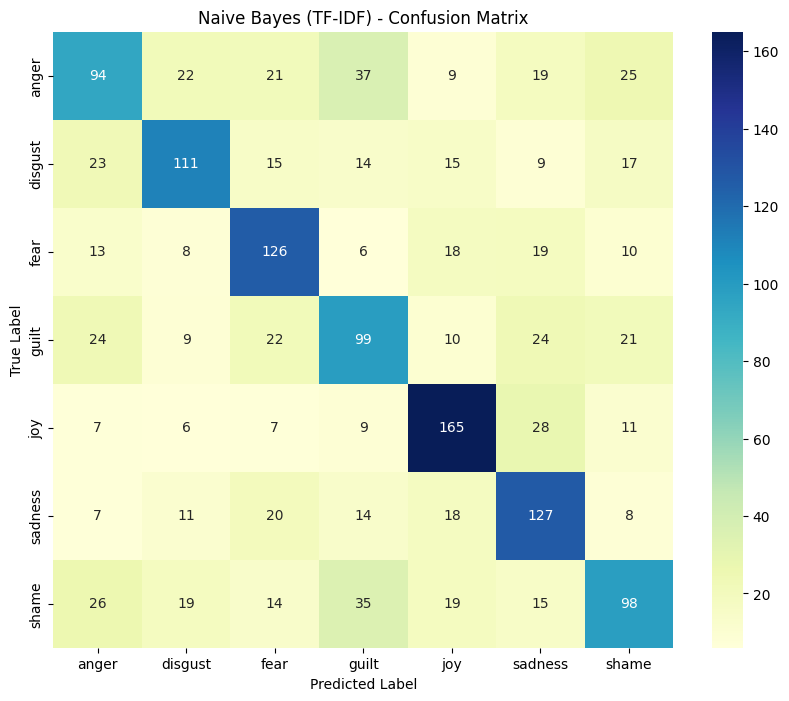

In [14]:
# Train a Basic Classifier
# Using a Naive Bayes classifier as a baseline for emotion classification
nb_classifier = MultinomialNB()
evaluate_model(nb_classifier, X_train_tfidf, y_train, X_test_tfidf, y_test, model_name="Naive Bayes (TF-IDF)")

## Decision Tree


Decision Tree (TF-IDF) - Classification Report:
               precision    recall  f1-score   support

       anger       0.38      0.34      0.36       227
     disgust       0.40      0.48      0.44       204
        fear       0.56      0.59      0.57       200
       guilt       0.35      0.33      0.34       209
         joy       0.57      0.55      0.56       233
     sadness       0.55      0.55      0.55       205
       shame       0.45      0.43      0.44       226

    accuracy                           0.47      1504
   macro avg       0.46      0.47      0.46      1504
weighted avg       0.46      0.47      0.46      1504

Decision Tree (TF-IDF) - Accuracy: 0.4654


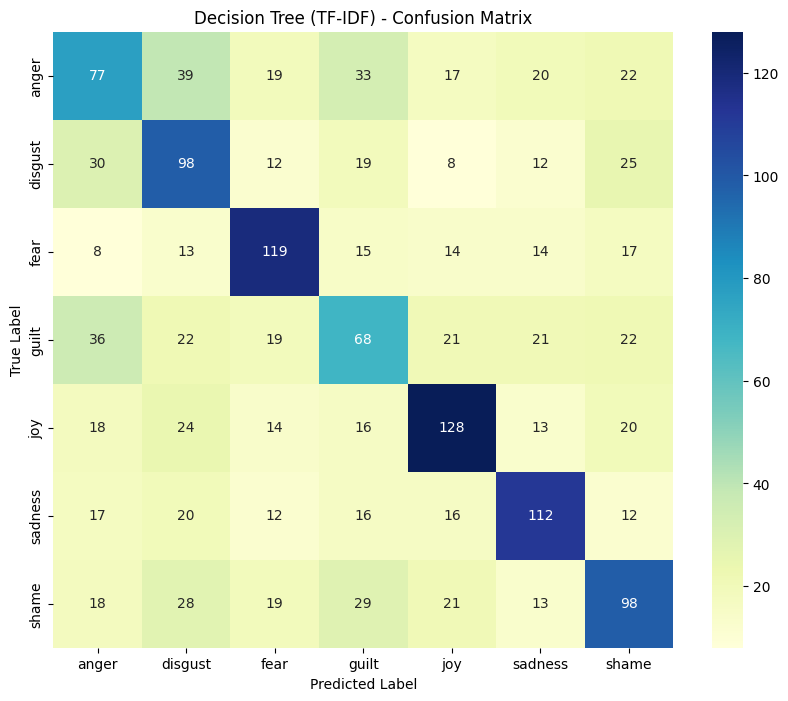

In [15]:
# Using a Decision Tree classifier as a baseline for emotion classification
dt_classifier = DecisionTreeClassifier(random_state=42)
evaluate_model(dt_classifier, X_train_tfidf, y_train, X_test_tfidf, y_test, model_name="Decision Tree (TF-IDF)")

## Logistic Regression


Logistic Regression (TF-IDF) - Classification Report:
               precision    recall  f1-score   support

       anger       0.49      0.46      0.48       227
     disgust       0.58      0.57      0.58       204
        fear       0.59      0.71      0.65       200
       guilt       0.50      0.45      0.48       209
         joy       0.68      0.73      0.71       233
     sadness       0.60      0.60      0.60       205
       shame       0.52      0.47      0.49       226

    accuracy                           0.57      1504
   macro avg       0.57      0.57      0.57      1504
weighted avg       0.57      0.57      0.57      1504

Logistic Regression (TF-IDF) - Accuracy: 0.5711


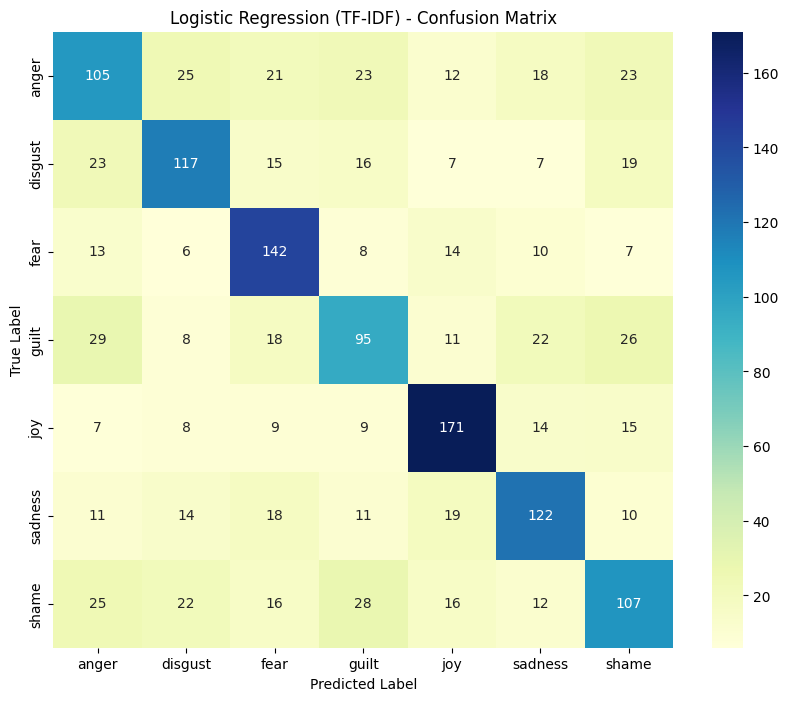

In [16]:
# Using a Logistic Regression classifier as a baseline for emotion classification
lr_classifier = LogisticRegression(max_iter=1000, random_state=42)
evaluate_model(lr_classifier, X_train_tfidf, y_train, X_test_tfidf, y_test, model_name="Logistic Regression (TF-IDF)")

## Random Forest


Random Forest (TF-IDF) - Classification Report:
               precision    recall  f1-score   support

       anger       0.45      0.37      0.41       227
     disgust       0.47      0.56      0.51       204
        fear       0.54      0.66      0.59       200
       guilt       0.51      0.46      0.48       209
         joy       0.63      0.72      0.67       233
     sadness       0.60      0.60      0.60       205
       shame       0.56      0.44      0.49       226

    accuracy                           0.54      1504
   macro avg       0.54      0.54      0.54      1504
weighted avg       0.54      0.54      0.54      1504

Random Forest (TF-IDF) - Accuracy: 0.5412


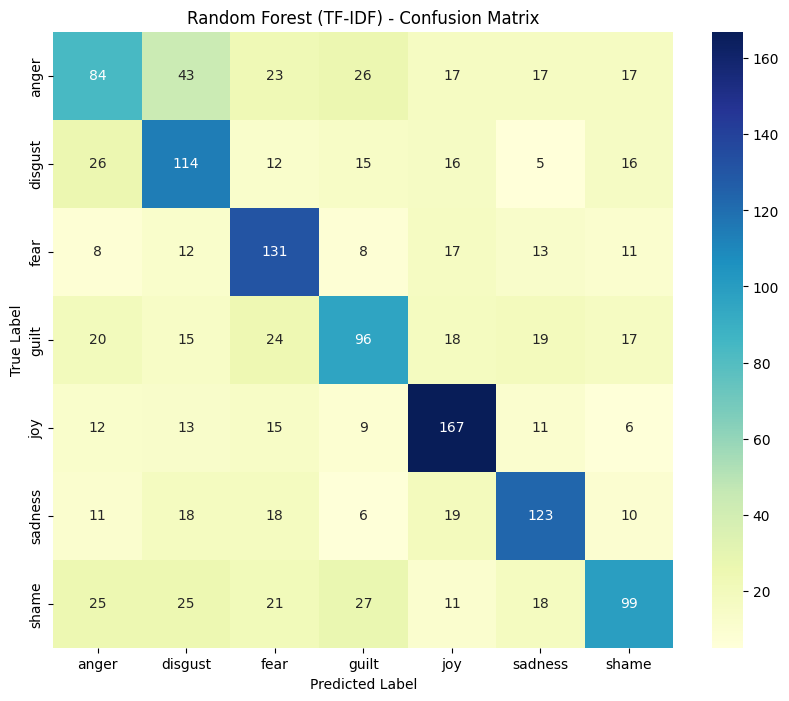

In [17]:
# Using a Random Forest classifier as a baseline for emotion classification
rf_classifier = RandomForestClassifier(class_weight='balanced', random_state=42)
evaluate_model(rf_classifier, X_train_tfidf, y_train, X_test_tfidf, y_test, model_name="Random Forest (TF-IDF)")

## Ensemble Voting Classifier


Ensemble Voting Classifier (TF-IDF)

Ensemble Voting Classifier (TF-IDF) - Classification Report:
               precision    recall  f1-score   support

       anger       0.40      0.36      0.38       227
     disgust       0.45      0.51      0.48       204
        fear       0.58      0.66      0.62       200
       guilt       0.38      0.34      0.36       209
         joy       0.60      0.61      0.61       233
     sadness       0.57      0.57      0.57       205
       shame       0.48      0.46      0.47       226

    accuracy                           0.50      1504
   macro avg       0.50      0.50      0.50      1504
weighted avg       0.50      0.50      0.50      1504

Ensemble Voting Classifier (TF-IDF) - Accuracy: 0.4993


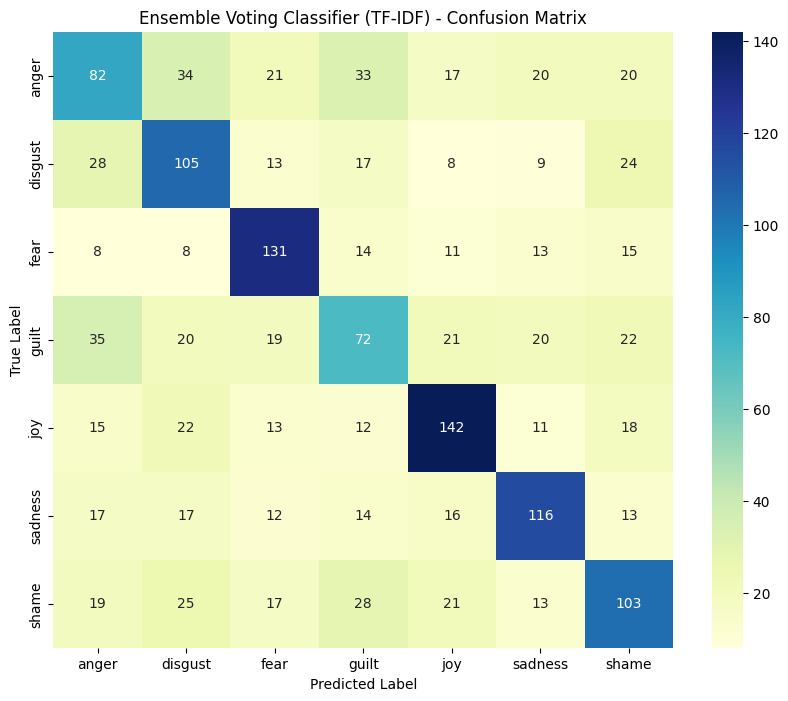

In [20]:
print("\nEnsemble Voting Classifier (TF-IDF)")
voting_classifier = VotingClassifier(
    estimators=[
        ('nb', nb_classifier),
        ('dt', dt_classifier),
        ('lr', LogisticRegression(max_iter=1000, random_state=42)),
        ('rf', RandomForestClassifier(class_weight='balanced', random_state=42))
    ],
    voting='soft'
)
evaluate_model(voting_classifier, X_train_tfidf, y_train, X_test_tfidf, y_test, model_name="Ensemble Voting Classifier (TF-IDF)")
